# Detecting optimal picking points for vine tomatoes

In [1]:
import argparse
import torch
from tqdm import tqdm
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from parse_config import ConfigParser
from torchvision import transforms

from utils import read_json, write_json

from matplotlib import cm
import matplotlib.pyplot as plt

In [5]:
model_file = "saved/0523_093001/model_best.pth"
config_file = "configTest.json"

## Load pretrained model and data

In [7]:
config = ConfigParser(read_json(config_file), model_file)

data_loader = getattr(module_data, config['data_loader']['type'])(
     config['data_loader']['args']['data_dir'],
     batch_size=3,
     shuffle=False,
     validation_split=0.0,
     training=False,
     num_workers=2
 )
 # build model architecture
model = config.init_obj('arch', module_arch)

# get function handles of loss and metrics
loss_fn = getattr(module_loss, config['loss'])
metric_fns = [getattr(module_metric, met) for met in config['metrics']]

checkpoint = torch.load(model_file, map_location=torch.device('cpu') if not torch.cuda.is_available() else None)
state_dict = checkpoint['state_dict']
if config['n_gpu'] > 1:
    model = torch.nn.DataParallel(model)
model.load_state_dict(state_dict)
# prepare model for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
total_loss = 0.0
total_metrics = torch.zeros(len(metric_fns))

['image_0_0.png', 'image_0_1.png', 'image_0_2.png', 'image_0_3.png', 'image_0_4.png']
['image_0_0_gtFine_labelIds.png', 'image_0_1_gtFine_labelIds.png', 'image_0_2_gtFine_labelIds.png', 'image_0_3_gtFine_labelIds.png', 'image_0_4_gtFine_labelIds.png']


## Run model on test set

  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([3, 1, 572, 572])


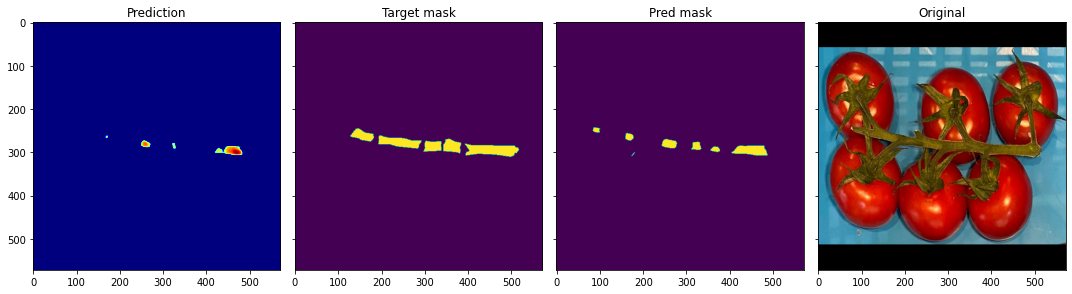

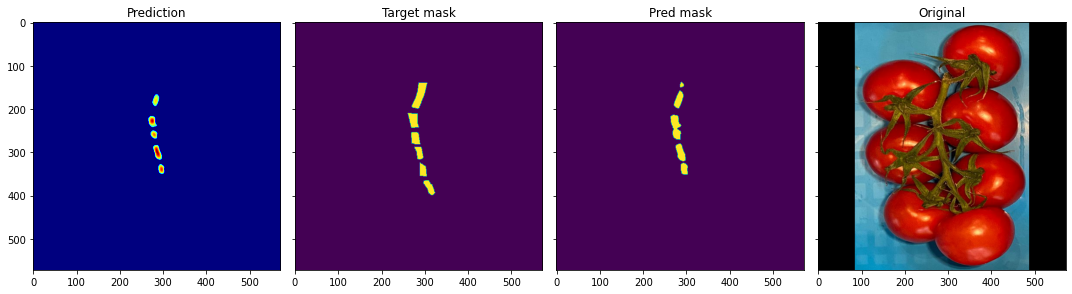

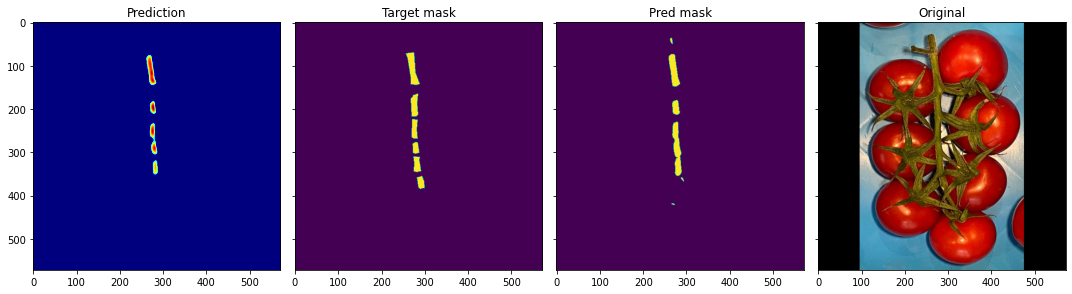

 50%|█████     | 1/2 [00:09<00:09,  9.01s/it]

torch.Size([2, 1, 572, 572])


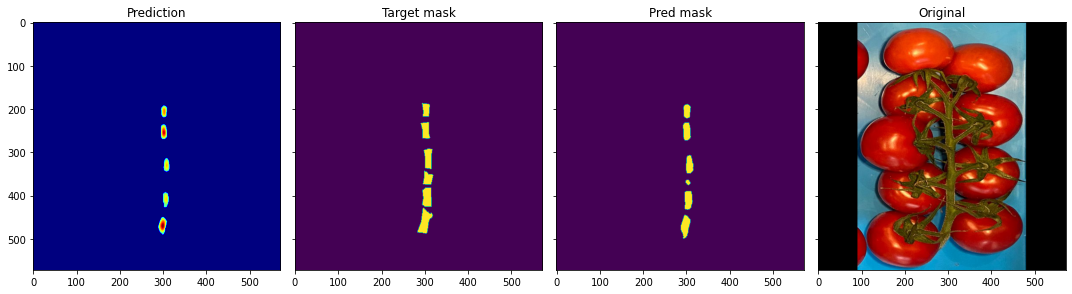

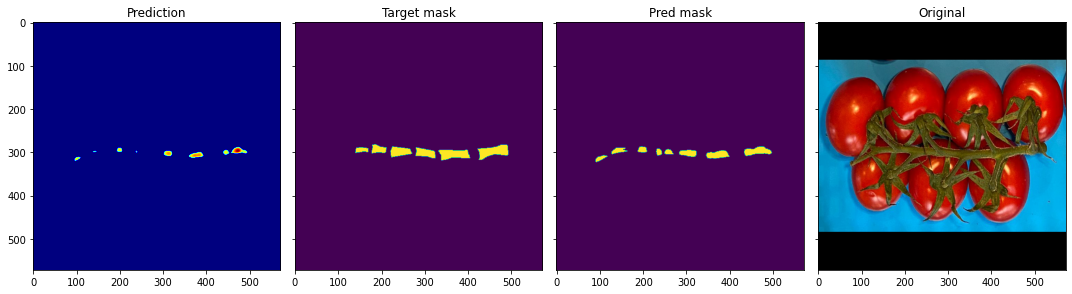

100%|██████████| 2/2 [00:22<00:00, 11.27s/it]


In [10]:
with torch.no_grad():
        for i, (data, target) in enumerate(tqdm(data_loader)):
            data, target = data.to(device), target.to(device)
            output = model(data)

            a = output
            b = target
            d = data
            try:
                output = output.cpu()
            except:
                output = a

            try:
                target = target.cpu()
            except:
                target = b

            try:
                data = data.cpu()
            except:
                data = d
            #
            # save sample images, or do something with output here
            #
            print(output.shape)
            for i in range(output.shape[0]):
                #transforms.Normalize(1, 1, inplace=True)(data[i, :, :])
                #transforms.Normalize(1, 1, inplace=True)(output[i, :, :])
                img = torch.nn.Softmax2d()(output[i])
                img = output[i,0,:,:]

                maskpred = (img > config["cutoff"]) * 255
                masktarget = target[i, 0, :, :]
                
                #dice_err = custom_loss(maskpred, masktarget)
                #print(dice_err)

                # plt.imshow(img, cmap='jet')
                # plt.show()

                fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharex=True, sharey=True)
                ax = axes.ravel()

                ax[0].imshow(img * (img > config['cutoff']), cmap=cm.jet)
                ax[0].set_title('Prediction')

                ax[1].imshow(target[i, 0, :, :])
                ax[1].set_title('Target mask')

                ax[2].imshow(maskpred)
                ax[2].set_title('Pred mask')

                original_input = data[i]
                original_input = original_input.transpose(0, 2)
                original_input = original_input.transpose_(0, 1)
                ax[3].imshow(original_input)
                ax[3].set_title('Original')

                plt.tight_layout()
                plt.show()
                # #plt.savefig("output/" + file.split("/")[-1])
                # plt.close()




            # computing loss, metrics on test set
            loss = loss_fn(output, target)
            batch_size = data.shape[0]
            total_loss += loss.item() * batch_size
            for i, metric in enumerate(metric_fns):
                total_metrics[i] += metric(output, target) * batch_size

### Print accuracy